# Курсовая работа по Data Science

Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Пропишем путь к датасету

In [2]:
TRAIN_DATA_PATH = './real-estate-price-prediction-moscow/train.csv'
TEST_DATA_PATH = './real-estate-price-prediction-moscow/test.csv'

Откроем тренировочный датасет

In [3]:
df = pd.read_csv(TRAIN_DATA_PATH, sep=',')
df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


## Еда

Приятного аппетита!

Проверим, какие признаки сильно коррелируются. Для линейной модели линейная корреляция является проблемой. UPD: Я больше не использую линейную модель, поэтому это не актуально

<AxesSubplot:>

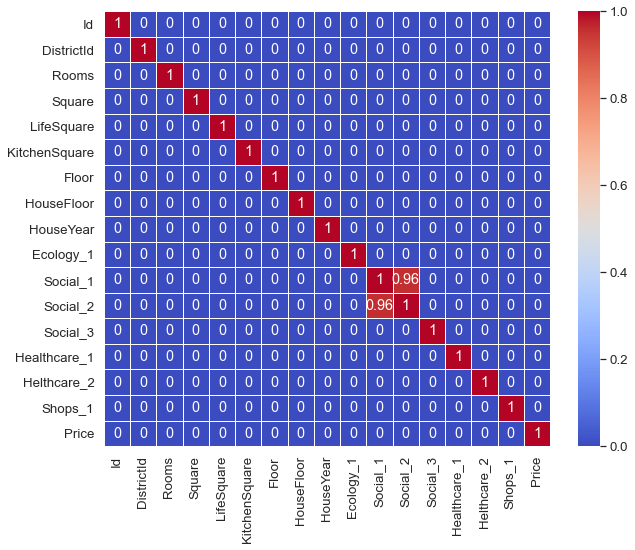

In [55]:
# Порог, после которого пара признаков считается сильно кореллирующей
high_correlation_threshold = 0.75

corr_matrix = np.round(df.corr(), 2)
corr_matrix[np.abs(corr_matrix) < high_correlation_threshold] = 0

plt.figure(figsize = (10,8))
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

Выведем пары сильно кореллирующих значений. Один признак из каждой пары удалим на этапе подготовки данных

In [5]:
for column in corr_matrix.columns:
    column_loc = corr_matrix.columns.get_loc(column)
    for row in range(len(corr_matrix.columns)):
        # После диагональной линии идет отзеркаленная часть,
        # не будем её рассматривать
        if column_loc == row:
            break
        if corr_matrix.iloc[row, column_loc] != 0:
            print(f"{column} {corr_matrix.columns[row]}")

Social_2 Social_1


## Подготовка данных

Изменим типы данных для сокращение потребляемой памяти. Для этого я буду использовать готовую функцию из вебинара

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 55.0%


Добавим функцию обнаружения выбросов по алгоритму Z-Score

In [8]:
def zscore(column):
    outliers = []
    threshold = 3.5
    mean = column.mean()
    std = column.std()
    for cell in column:
        z_score = (cell - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(cell)
    return outliers

Добавим функцию конвертации категориальных переменных в дамми

In [9]:
def convert_to_dummies(df, col):
    if col not in df.columns:
        return df
    
    new_df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    new_df.drop(col, axis=1, inplace=True)
    return new_df

Поделим данные на тренировочную и тестовую выборку

In [76]:
from sklearn.model_selection import train_test_split


X = df.drop("Price", axis=1) # Признаки
y = df["Price"] # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Подготовим данные

In [77]:
from sklearn.decomposition import PCA


class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        self.cols_to_drop = None
        # Медиана, а не среднее арифметическое, потому что медиана
        # не смещается из-за выбросов
        self.medians = None
        self.cols_with_missing = None
        self.initial = None
        
        # Районы
        self.district_median_price_per_square = None
        self.district_median_square = None
        self.district_median_year = None
        
    def fit(self, df, y):
        """Сохранение статистик"""
        
        # Создадим пары признаков на слияние
        
        self.merge_features = [
            ["Social_1", "Social_2"]
        ]
        
        # Отметим столбцы с незаполненными ячейками
        
        self.cols_with_missing = [col for col in df.columns 
                                 if df[col].isnull().any()]
        
        # Скопируем нужные признаки из изначального состояния
        
        """self.initial = df.copy()
        for col in df.columns:
            if df[col].dtype == 'object' or col in self.cols_to_drop:
                self.initial.drop(col, axis=1, inplace=True)
        """
                
        self.initial = pd.DataFrame(None, columns=[col for col in df.columns
                                                   if df[col].dtype != 'object'])
        
        # Раcчитаем медианные значения
        
        self.medians = {}
        for col in self.initial.columns:
            self.medians[col] = df[col].median()
            
        # Расчитаем матрицу корреляции признаков
        """
        self.initial_corr = self.initial.corr()
        """
        
        # Расчитаем медианные значения районов
        
        self.district_median_square = df.groupby(['DistrictId'])['Square'].agg('median')
        self.district_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median')
        df_with_price = df.copy()
        df_with_price['Price'] = y
        self.district_median_price_per_square = df_with_price.groupby(['DistrictId'])['Price'].agg('median') \
            / self.district_median_square
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        
        for col in self.cols_with_missing:
            df[col + '_was_missing'] = df[col].isnull()
            df[col].fillna(self.medians[col], inplace=True)
            
            """ # Этот код понижает точность модели до 0.66
            
            corr_with = [i for i in range(len(self.initial_corr.columns))
                         if self.initial_corr.iloc[i, self.initial_corr.columns.to_list().index(col)] > 0.5]
            df_column_list = df.columns.to_list()
            
            for row in range(len(df[col])):
                values = [self.initial.iloc[row, i] for i in corr_with]
                values.append(self.medians[col])
                df.iloc[row, df_column_list.index(col)] = np.nanmean(np.asarray(values))
            """
        
        # 2. Выбросы
        
        for col in self.initial.columns:
            df.loc[df[col].isin(zscore(df[col])), col] = self.medians[col]
        
        # 3. Новые признаки
        
        features_to_dummy = [
            "Ecology_2", "Ecology_3", "Shops_2"
        ]
        
        for feature in features_to_dummy:
            df = convert_to_dummies(df, feature)
        
        df['DistrictPricePerSquare'] = df['DistrictId'].map(self.district_median_price_per_square)
        df['DistrictSquare'] = df['DistrictId'].map(self.district_median_square)
        df['DistrictYear'] = df['DistrictId'].map(self.district_median_year)
        
        # Некоторые значение всё еще не заполнены
        
        new_cols_to_fillna = [
            'DistrictPricePerSquare', 'DistrictSquare', 'DistrictYear'
        ]
        
        for col in new_cols_to_fillna:
            df[col].fillna(df[col].median(), inplace=True)
            
        # 4. Линейно кореллирующие признаки
        # Как показывает практика, их стоит удалять не только
        # при использовании линейной модели
        
        pca = PCA(n_components=1, random_state=42)
        
        for corr_features in self.merge_features:
            df['_'.join(corr_features)] = pca.fit_transform(df[corr_features])
            df.drop(corr_features, axis=1, inplace=True)
        
        # 5. Удаление уникальных идентификаторов наблюдений
        
        df.drop("Id", axis=1, inplace=True)
        
        return df

In [78]:
pipe = DataPipeline()
pipe.fit(X_train, y_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

<ipython-input-77-a6730f05de6a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_was_missing'] = df[col].isnull()
c:\users\blaze\scoop\apps\python\3.9.1\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
c:\users\blaze\scoop\apps\python\3.9.1\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [81]:
X_train.head(3)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_3,...,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictPricePerSquare,DistrictSquare,DistrictYear,Social_1_Social_2
9069,31.0,1.0,38.234364,20.008121,8.0,6.0,3.0,1977.0,0.000000,2.0,...,0,1,0,1,0,1,5092.528809,56.915462,1977.0,-1658.085937
2603,11.0,1.0,31.309444,24.479166,5.0,1.0,5.0,1969.0,0.038693,1.0,...,0,1,0,1,0,1,4214.781250,48.642700,1973.0,1190.910077
7738,123.0,2.0,47.234447,19.363581,6.0,2.0,12.0,1980.0,0.000000,0.0,...,0,1,0,1,0,1,4724.039551,68.493011,2005.5,5976.947685


Визуализируем два корреллирующих признака. Где диагональная линия, там сильная корреляция. Хвостики это заполненные пропущенные значения. Я пробовал по умному их заполнить, но сильно понизил точность модели, поэтому я закоментировал этот код

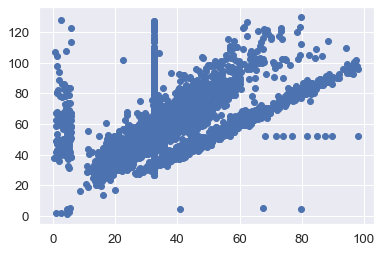

In [14]:
# ls_color = X_train["LifeSquare_was_missing"]
plt.scatter(x=X_train["LifeSquare"], y=X_train["Square"])
plt.show()

Перед обучением стандартизируем признаки. Я не буду стандартизировать, у меня с этим проблема: точность модели понижается до -2.5

In [15]:
from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Обучение и предсказание

По сетке найдем наилучшую конфигурацию модели градиентного бустинга, используя кросс валидацию

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV


params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=10,
                                     random_state=42),
                  params, # список возможных параметров
                  scoring='r2', # метрика качества 
                  cv=KFold(n_splits=5, # количество разбиений в кросс-валидации
                           random_state=42, 
                           shuffle=True), # перемешаем данные
                  n_jobs=-1) # используем все ядра процессора

# Я закометирую строчки с обучением, чтобы случайно не запустились.
# Обучение и кросс валидация очень долго длятся, а лучшие
# гиперпараметры уже извесны

# gs.fit(X_train, y_train)
# gs.best_params_ # получим наилучш

Посмотрим оценку кросс валидации наилучшей модели на тренировочных данных

In [17]:
# gs.best_score_

Создадим и обучим модель градиентного бустинга с ~~наилучшей конфигурацией~~ конфигурацией из другого нотбука

In [79]:
model = GradientBoostingRegressor(criterion='mse',
                                  max_depth=6,
                                  min_samples_leaf=50,
                                  random_state=42,  
                                  n_estimators=2250,
                                  learning_rate=0.025,
                                  max_features='sqrt',
                                  loss='huber')
model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)

Загрузим тестовые данные и обработаем их

In [82]:
test_data = pd.read_csv(TEST_DATA_PATH, sep=',')

# Сохраним ID всех строк. DataPipeline удалит столбец Id, но все строки оставит
test_data_ids = test_data["Id"]

test_data = pipe.transform(test_data)
test_data.head(4)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_3,...,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictPricePerSquare,DistrictSquare,DistrictYear,Social_1_Social_2
0,44.0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970.0,0.036122,0.0,...,0,1,0,1,0,1,4475.790527,46.209560,1974.0,-1028.894976
1,62.0,1.0,42.493907,42.568133,10.0,7.0,17.0,2017.0,0.072158,1.0,...,0,1,0,1,1,0,2814.751709,56.840710,1977.0,-4777.954067
2,27.0,2.0,59.463678,32.616951,9.0,19.0,19.0,1977.0,0.211401,0.0,...,0,1,0,1,0,1,2661.375244,54.829494,1977.0,-3514.935873
3,23.0,3.0,49.646030,33.893825,6.0,2.0,2.0,1965.0,0.014073,0.0,...,0,1,0,1,0,1,2099.979004,54.245842,1977.0,-4931.952734


Предскажем цену на недвижимость на этих данных

In [83]:
test_pred = model.predict(test_data)
test_pred

array([168944.13057742, 117945.34170641, 135897.93641672, ...,
       151506.72007433, 189067.73337835, 316789.68218643])

Преобразуем в формат, который распознаст Kaggle

In [84]:
test_pred_output = pd.DataFrame({"Id": test_data_ids, "Price": test_pred})
test_pred_output.head()

,Id,Price
0,4567,168944.130577
1,5925,117945.341706
2,960,135897.936417
3,3848,95757.249998
4,746,170605.563838


Сохраним предсказания в файл

In [85]:
test_pred_output.to_csv("submission.csv", index=False)